# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

<font size = 3><b>Загрузим данные через загрузчик данных</b></font>

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
#посмотрим на количество изображений
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В нашем распоряжении находятся 7591 изображение, а датасет содержит два столбца: название файла с фотографией и возраст изображенного на ней человека.

In [4]:
#подготовим признаки для обучения
features, target = next(train_gen_flow)

print(features.shape) 

(32, 224, 224, 3)


Получили четырёхмерный тензор, в котором 32 изображения размером 224х224 с тремя цветовыми каналами.

<font size = 3><b>Посмотрим график распределения возраста в выборке.</b></font>

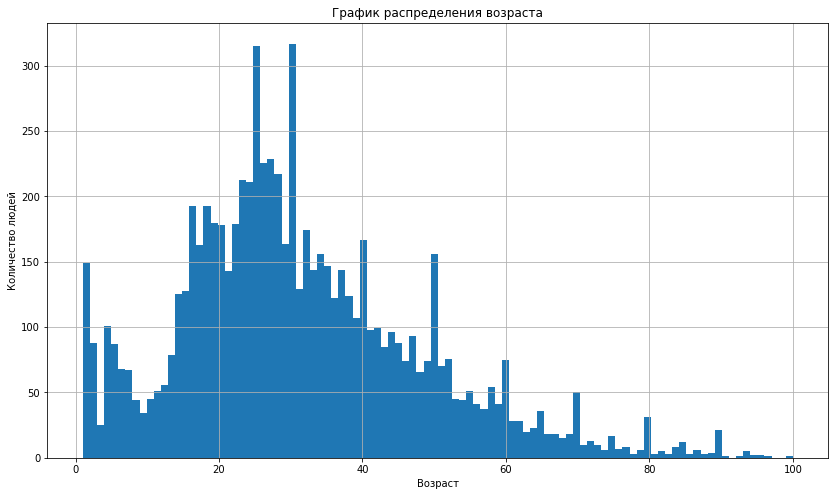

In [5]:
labels['real_age'].hist(bins=100, figsize=(14,8))
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('График распределения возраста')
plt.show()

In [6]:
#и посмотрим на описательную статистику
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

На гистограмме видно, что у нас есть фотографии людей в возрасте от 1 года до 100 лет, причем фотографий детей до 10 лет намного больше, чем людей после 60 лет. Основная масса фотографий приходится на возраст от 18 до 36 лет, а среднее значение - 31 год. Также видны пики на 30, 40, 50, 60, 70, 80 и 90 лет, что может говорить об округлении возраста при подготовке данных до десятилетий.

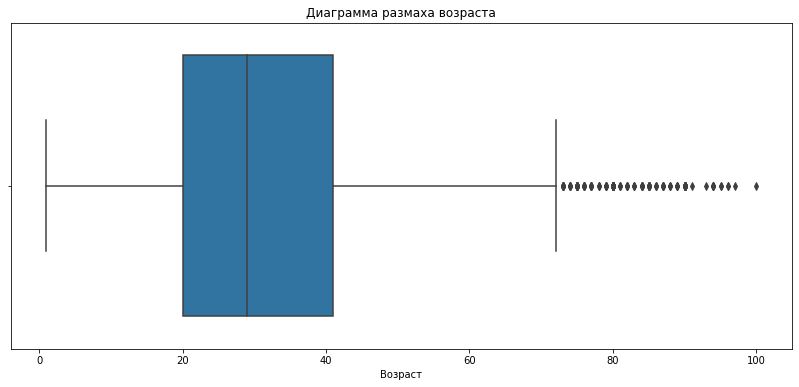

In [7]:
#посмотрим на boxplot
plt.figure(figsize=(14,6))
sns.boxplot(labels['real_age'])
plt.title("Диаграмма размаха возраста")
plt.xlabel("Возраст")
plt.show()

В целом распределение нормальное, выбросы начинаются примерно с 73 лет.

И теперь посмотрим на 15 случайных фотографий из нашего набора для обучения.

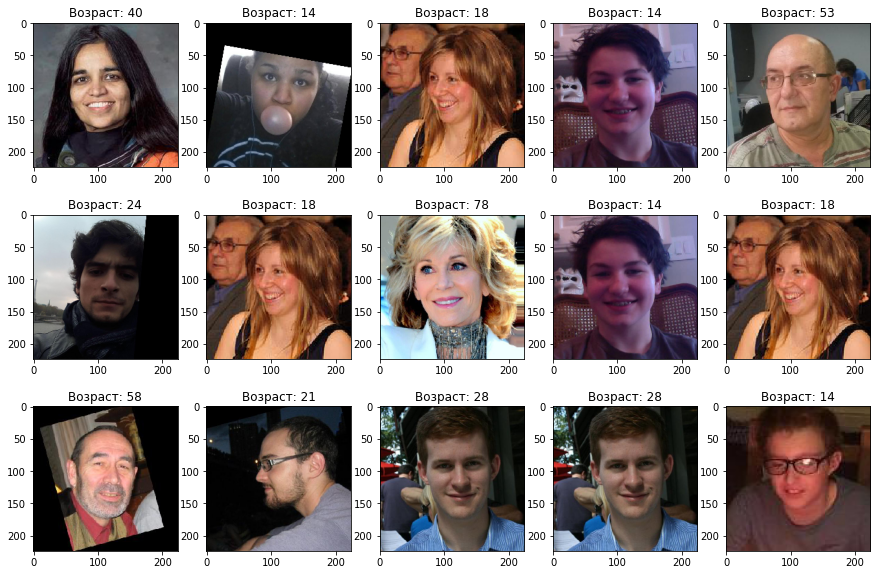

In [8]:
fig, ax = plt.subplots(3,5,figsize = (15,10))
ax = ax.ravel()
for i in range(15):
    rand = np.random.randint(len(features))
    image = features[rand]
    ax[i].imshow(image)
    ax[i].set_title('Возраст: {}'.format(target[rand]))
plt.show()

Видим, что фото абсолютно разные: цветные, черно-белые, с наклонами, с рамками и т.д., что не очень хорошо для обучения модели.

<font size = 4><b>Вывод по разделу</b></font>

1. Были загружены необходимые библиотеки и подготовлены признаки для обучения.
2. У нас в наличии 7591 изображение, что достаточно мало для обучения, поэтому для увеличения выборки применим аугментацию.
3. В выборке присутствуют фотографии людей от 1 года до 100 лет, распределение в целом нормальное, есть выбросы после 73 лет.
4. По визуальной оценке фото неплохого качества и с разными особеностями: черно-белые, с наклонами, с рамками и т.д., что усложнит обучение модели:
    - В датасете есть фотографии, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл сделать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение, так и объект отдельно от фона;
    - В датасете есть фотографии, на которых лица изображены в полупрофиль. Имеет смысл сделать аугментацию с отражением по горизонтали в некотором проценте случаев;
    - В датасете есть фотографии с разным разрешением. Имеет смысл сделать аугментацию с изменением контрастности изображения в некотором проценте случаев;
    - В датасете есть фотографии, на которых изображены не лица, а голова и часть туловища (иногда человек полностью). Имеет смысл сделать аугментацию с обрезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица плюс-минус одного масштаба.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

    import numpy as np
    import pandas as pd
    from tensorflow.keras.layers import  Flatten, Dense, GlobalAveragePooling2D
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications.resnet import ResNet50 

    optimizer = Adam(lr=0.0001)

    def load_train(path):
        labels = pd.read_csv(path+'labels.csv')                                                     
        train_datagen = ImageDataGenerator(rescale= 1./255, horizontal_flip=True, validation_split=0.25)  
        train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe = labels,
            directory = path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)
        return train_datagen_flow

    def load_test(path):
        labels = pd.read_csv(path+'labels.csv')  
        test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
        test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe = labels,
            directory = path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation', 
            seed=12345)

        return test_datagen_flow

    def create_model(input_shape):

        backbone = ResNet50(input_shape= input_shape,
                        weights='imagenet', 
                        include_top= False)

        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1, activation='relu'))
        model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) 
        return model


    def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                    steps_per_epoch=None, validation_steps=None):

        model.fit(train_data, 
                  validation_data= test_data,
                  batch_size=batch_size, epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  verbose=2)
        return model

```
Train for 178 steps, validate for 60 steps
Epoch 1/15
2022-07-18 12:27:24.423712: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-18 12:27:24.743183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 68s - loss: 252.2364 - mae: 11.4286 - val_loss: 775.4850 - val_mae: 22.9270
Epoch 2/15
178/178 - 37s - loss: 76.8026 - mae: 6.6080 - val_loss: 445.2631 - val_mae: 15.8502
Epoch 3/15
178/178 - 37s - loss: 50.9350 - mae: 5.4355 - val_loss: 255.9683 - val_mae: 11.7313
Epoch 4/15
178/178 - 38s - loss: 38.8207 - mae: 4.7104 - val_loss: 116.4448 - val_mae: 8.2624
Epoch 5/15
178/178 - 37s - loss: 27.4397 - mae: 3.9957 - val_loss: 85.6771 - val_mae: 6.9618
Epoch 6/15
178/178 - 38s - loss: 21.2499 - mae: 3.5423 - val_loss: 67.2456 - val_mae: 6.1570
Epoch 7/15
178/178 - 37s - loss: 16.7358 - mae: 3.1481 - val_loss: 75.7624 - val_mae: 6.6952
Epoch 8/15
178/178 - 38s - loss: 13.4297 - mae: 2.8473 - val_loss: 64.8759 - val_mae: 5.9542
Epoch 9/15
178/178 - 38s - loss: 11.7020 - mae: 2.5989 - val_loss: 63.8381 - val_mae: 5.9774
Epoch 10/15
178/178 - 38s - loss: 11.5853 - mae: 2.5715 - val_loss: 68.3620 - val_mae: 6.2394
Epoch 11/15
178/178 - 38s - loss: 9.9062 - mae: 2.4252 - val_loss: 64.1257 - val_mae: 5.9766
Epoch 12/15
178/178 - 38s - loss: 8.9097 - mae: 2.2758 - val_loss: 64.2800 - val_mae: 5.8669
Epoch 13/15
178/178 - 38s - loss: 9.0347 - mae: 2.2601 - val_loss: 65.7349 - val_mae: 5.9653
Epoch 14/15
178/178 - 38s - loss: 7.6941 - mae: 2.0876 - val_loss: 66.1433 - val_mae: 6.1230
Epoch 15/15
178/178 - 37s - loss: 7.2648 - mae: 2.0595 - val_loss: 61.0023 - val_mae: 5.7605

60/60 - 9s - loss: 61.0023 - mae: 5.7605
Test MAE: 5.7605
```

Достигнут отличный результат MAE - 5.7605 при помощи нейросети ResNet50.

## Анализ обученной модели

В имеющемся датасете содержится 7591 фотографий размером 224х224, среди которых были фотографии со слабым освещением, черно-белые, размытые, с частичным поворотом и т.д. Нам была поставлена задача регрессии по определению возраста человека по фотографии, а МАЕ модели на тестовой выборке не должен превышать 8.

Для обучающей выборки было взято 75% фотографией с аугментацией horizontal_flip, а 25% фотографий оставили в тестовой выборке без изменений.

Для обучения использовалась нейросеть ResNet50, которая дополнительно была обучена на имеющихся данных. В модели на выходе использовался только 1 нейрон, который должен вернуть число-предсказание возраста, с активацией relu, т.к. она отрицательные числа приводит к нулю, а возраст отрицательным быть не может. Также был использован оптимизатор Adam с learning rate 0.0001. В качестве функции потерь использовался Mean Squared Error, т.к. он подходит для задачи регрессии.

Обученная модель была протестирована на 15 эпохах, метрика МАЕ 5.7605 достигнута на 15 эпохе.

Модель успешно обучена, метрика МАЕ сильно ниже целевой, установленной в 8, а это значит, что нашу модель можно использовать.

Плюс несколько рекомендаций к предсталяемым для обучения фотографиям. Их выполнение позволит повысить качество обучения модели и еще снизить среднюю ошибку:
- В датасете есть фотографии, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл сделать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение, так и объект отдельно от фона;
- В датасете есть фотографии, на которых лица изображены в полупрофиль. Имеет смысл сделать аугментацию с отражением по горизонтали в некотором проценте случаев;
- В датасете есть фотографии с разным разрешением. Имеет смысл сделать аугментацию с изменением контрастности изображения в некотором проценте случаев;
- В датасете есть фотографии, на которых изображены не лица, а голова и часть туловища (иногда человек полностью). Имеет смысл сделать аугментацию с обрезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица плюс-минус одного масштаба.